# 2020.08.06 AIFFEL LMS Exploration 4 Project
   
   * 이미지 분류기 만들기

Step 1. 데이터셋 내려받기

 - tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용
 - tfds.load를 활용하여 데이터셋을 다운 받을 것

In [1]:
# 버전 문제로 인한 경고 무시를 위한 코드
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 텐서플로우 데이터 셋 호출 및 버전 확인

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

In [3]:
# 데이터 변수 저장

# train 데이터와 validation 데이터, test데이터를각각 80:10:10 비율로 분리 

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
# 데이터 타입 확인

print(raw_train)
print(raw_validation)
print(raw_test)

print(type(raw_train))
print(type(raw_validation))
print(type(raw_test))

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


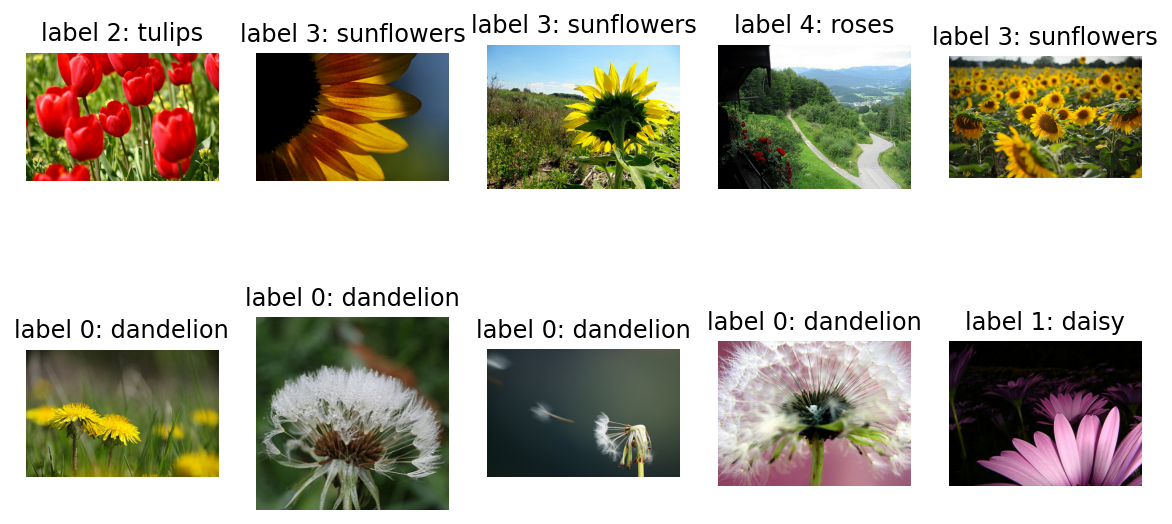

In [5]:
# 데이터 시각화 및 확인

#라이브러리 호출
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str
 
# take(10) : 10개 만큼 데이터를 추출하여 새로운 데이터셋 인스턴스를 만듬 
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

 - 이미지를 모두 같은 크기로 formatting 한 후, 
 - train_batches, validation_batches, test_batches를 준비

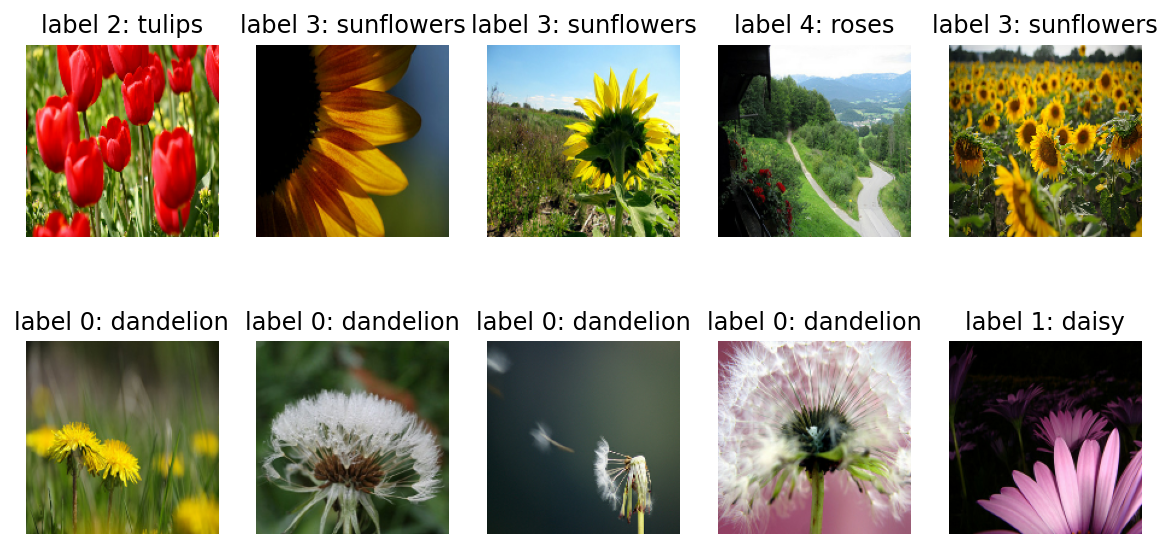

In [6]:
# 모든 이미지를 동일한 사이즈 160*160으로 변경

IMG_SIZE = 160

# 이미지 사이즈 변경 함수 정의
def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    

    image = (image/127.5) - 1
    # image 데이터의 픽셀은 0~255 사이의 값이며,
    # 그들의 중간 값인 127.5로 나누고 1을 뺐으므로,
    # -1~1 사이의 실수 값으로 변경됨
    
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# 이미지 사이즈 변경 수행
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 사이즈 변경 된 이미지 출력 및 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [7]:
# 모델을 학습시킬 데이터를 준비

# BATCH_SIZE : 한 스텝에 학습시킬 데이터의 개수 = 32개
# 전체 데이터 셋에서 32개씩 묶어서 한 batch로 정하고 학습
BATCH_SIZE = 32

# SHUFFLE_BUFFER_SIZE : 학습 데이터를 적절히 섞어줄 버퍼의 크기 설정
# 데이터 셋은 버퍼 라는 공간에 담겨져 순서가 랜덤하게 섞이는데, 그 버퍼의 크기
# 데이터가 완벽하게 섞이기 위해서는 버퍼의 크기거 전체 데이터셋의 크기보다 크거나 같아야 한다.
SHUFFLE_BUFFER_SIZE = 10000

# 전체 데이터에서 32개를 랜덤으로 뽑아 제공
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE).repeat()
validation_batches_fit = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
# 하나의 batch만 뽑아서 확인

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

# 32 : 데이터의 갯수
# 160 : 이미지 높이의 크기
# 160 : 이미지 너비의 크기
# 3 : 채널수 (RGB)
# label이 단 하나의 숫자인 이유 : 고양이, 강아지를 구분하는 1차원 숫자만 필요하므로

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

Step 3. 모델 설계하기

 -  tf_flowers 데이터셋에서는 class의 갯수가 5가지임에 유의

In [9]:
# 모델 설계 - Xception V1 모델 이용

# 이미지 분류를 위한 Xception V1 모델 추가

import tensorflow as tf
from tensorflow.python.keras.applications.xception import Xception

# tf.keras.applications.Xception??

In [10]:
# 이미지 분류를 위한 Xception V1 모델을 이용하여 base model 설계

IMG_SHAPE  = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


In [11]:
# 모델에 이미지 적용 후 사이즈 확인

feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 2048])

In [12]:
# 차원 축소 함수 global_average_layer 변수 지정
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# 모델이 출력한 feature_batch에 대한 차원 축소 수행
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [13]:
# Dense 레이어들을 Base model에 붙여줌

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

base_model.trainable = False

# 최종 모델 만들기

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

(32, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 1,051,653
Non-trainable params: 20,861,480
_________________________________________________________________


Step 4. 모델 학습

 - 여기에서는 여러 가지 옵션을 바꿔볼 수 있음
 - 예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나,
 - learning_rate 값을 바꿔볼 수 있음
 - 또는, optimizer의 종류도 바꿔볼 수 있음
 - VGG16이 아닌 다른 모델을 base model로 활용할 수도 있음
 - 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수도 있음
 - Dropout이나 Batch Normalization을 적용하는 등 Regularization 기법이 적용

In [14]:
# optimizer, loss, metrics를 준비해서 모델을 compile 

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [15]:
# 초기 손실과 정확도 값을 확인

validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 21s 1s/step - loss: 1.7240 - accuracy: 0.2456
initial loss: 1.72
initial accuracy: 0.25


In [16]:
# 5번에 모델 학습 수행
# Validation_batches를 이용한 정확도 및 손실 검증

EPOCHS = 5  

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches_fit)

Epoch 1/5
92/92 [==============================] - 28s 301ms/step - loss: 0.7045 - accuracy: 0.7606 - val_loss: 0.5099 - val_accuracy: 0.8229
Epoch 2/5
92/92 [==============================] - 5s 53ms/step - loss: 0.4242 - accuracy: 0.8566 - val_loss: 0.3962 - val_accuracy: 0.8556
Epoch 3/5
92/92 [==============================] - 5s 53ms/step - loss: 0.3379 - accuracy: 0.8879 - val_loss: 0.3751 - val_accuracy: 0.8474
Epoch 4/5
92/92 [==============================] - 5s 53ms/step - loss: 0.2866 - accuracy: 0.9111 - val_loss: 0.3366 - val_accuracy: 0.8801
Epoch 5/5
92/92 [==============================] - 5s 54ms/step - loss: 0.2464 - accuracy: 0.9230 - val_loss: 0.3268 - val_accuracy: 0.8828


Step 5. 모델 성능 평가하기

 - 모델이 학습된 과정을 그래프로도 그려보고, 
 - validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 볼 것


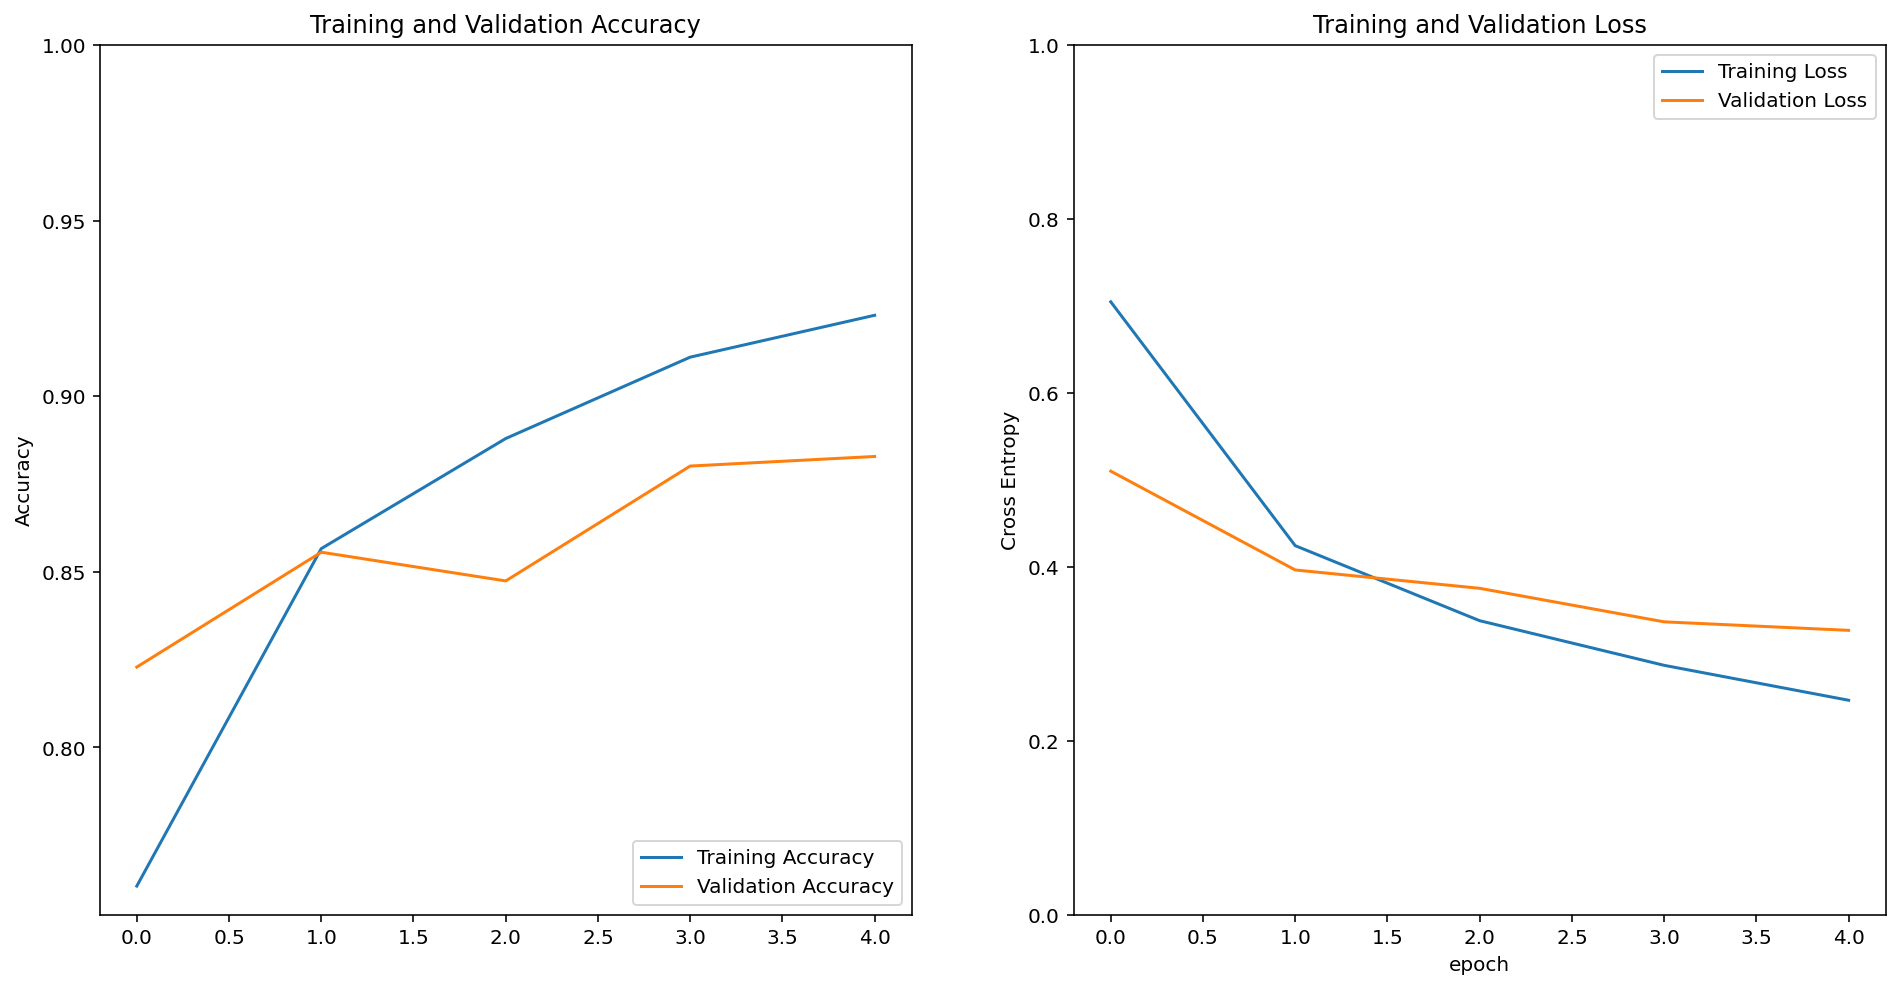

In [17]:
# 그래프를 통하여 모델학습 과정 간 정확도 변화를 그래프로 확인

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# test_batches를 가져와서 예측 결과 확인

for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[6.28610002e-03, 2.59135924e-02, 8.28430295e-01, 6.36002002e-03,
        1.33010015e-01],
       [9.99998689e-01, 5.03631725e-07, 2.07243332e-07, 4.54317018e-07,
        6.85578598e-08],
       [2.37504154e-01, 2.78150220e-03, 1.55070171e-01, 5.98551750e-01,
        6.09240169e-03],
       [4.01218142e-03, 1.00938212e-02, 8.68887186e-01, 2.31249112e-04,
        1.16775587e-01],
       [8.23918700e-01, 1.27953559e-01, 2.17446289e-03, 4.03060503e-02,
        5.64729655e-03],
       [9.48971450e-01, 2.31402107e-02, 5.43442089e-03, 1.82084031e-02,
        4.24553407e-03],
       [5.20081073e-03, 2.07744259e-03, 9.90113258e-01, 8.33002268e-04,
        1.77540549e-03],
       [3.97095531e-01, 2.33901113e-01, 1.87167585e-01, 1.27412841e-01,
        5.44229373e-02],
       [3.53598371e-02, 1.52013672e-04, 6.58548577e-03, 9.50966299e-01,
        6.93634292e-03],
       [9.99983788e-01, 2.05763126e-06, 1.21122767e-07, 1.36846475e-05,
        3.10328375e-07],
       [9.90075052e-01, 8.1353

In [20]:
#  prediction 값들을 실제 추론한 라벨로 변환

import numpy as np

predictions = np.argmax(predictions, axis=1)

predictions

array([2, 0, 3, 2, 0, 0, 2, 0, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 4, 1, 4, 2, 3, 0, 4])

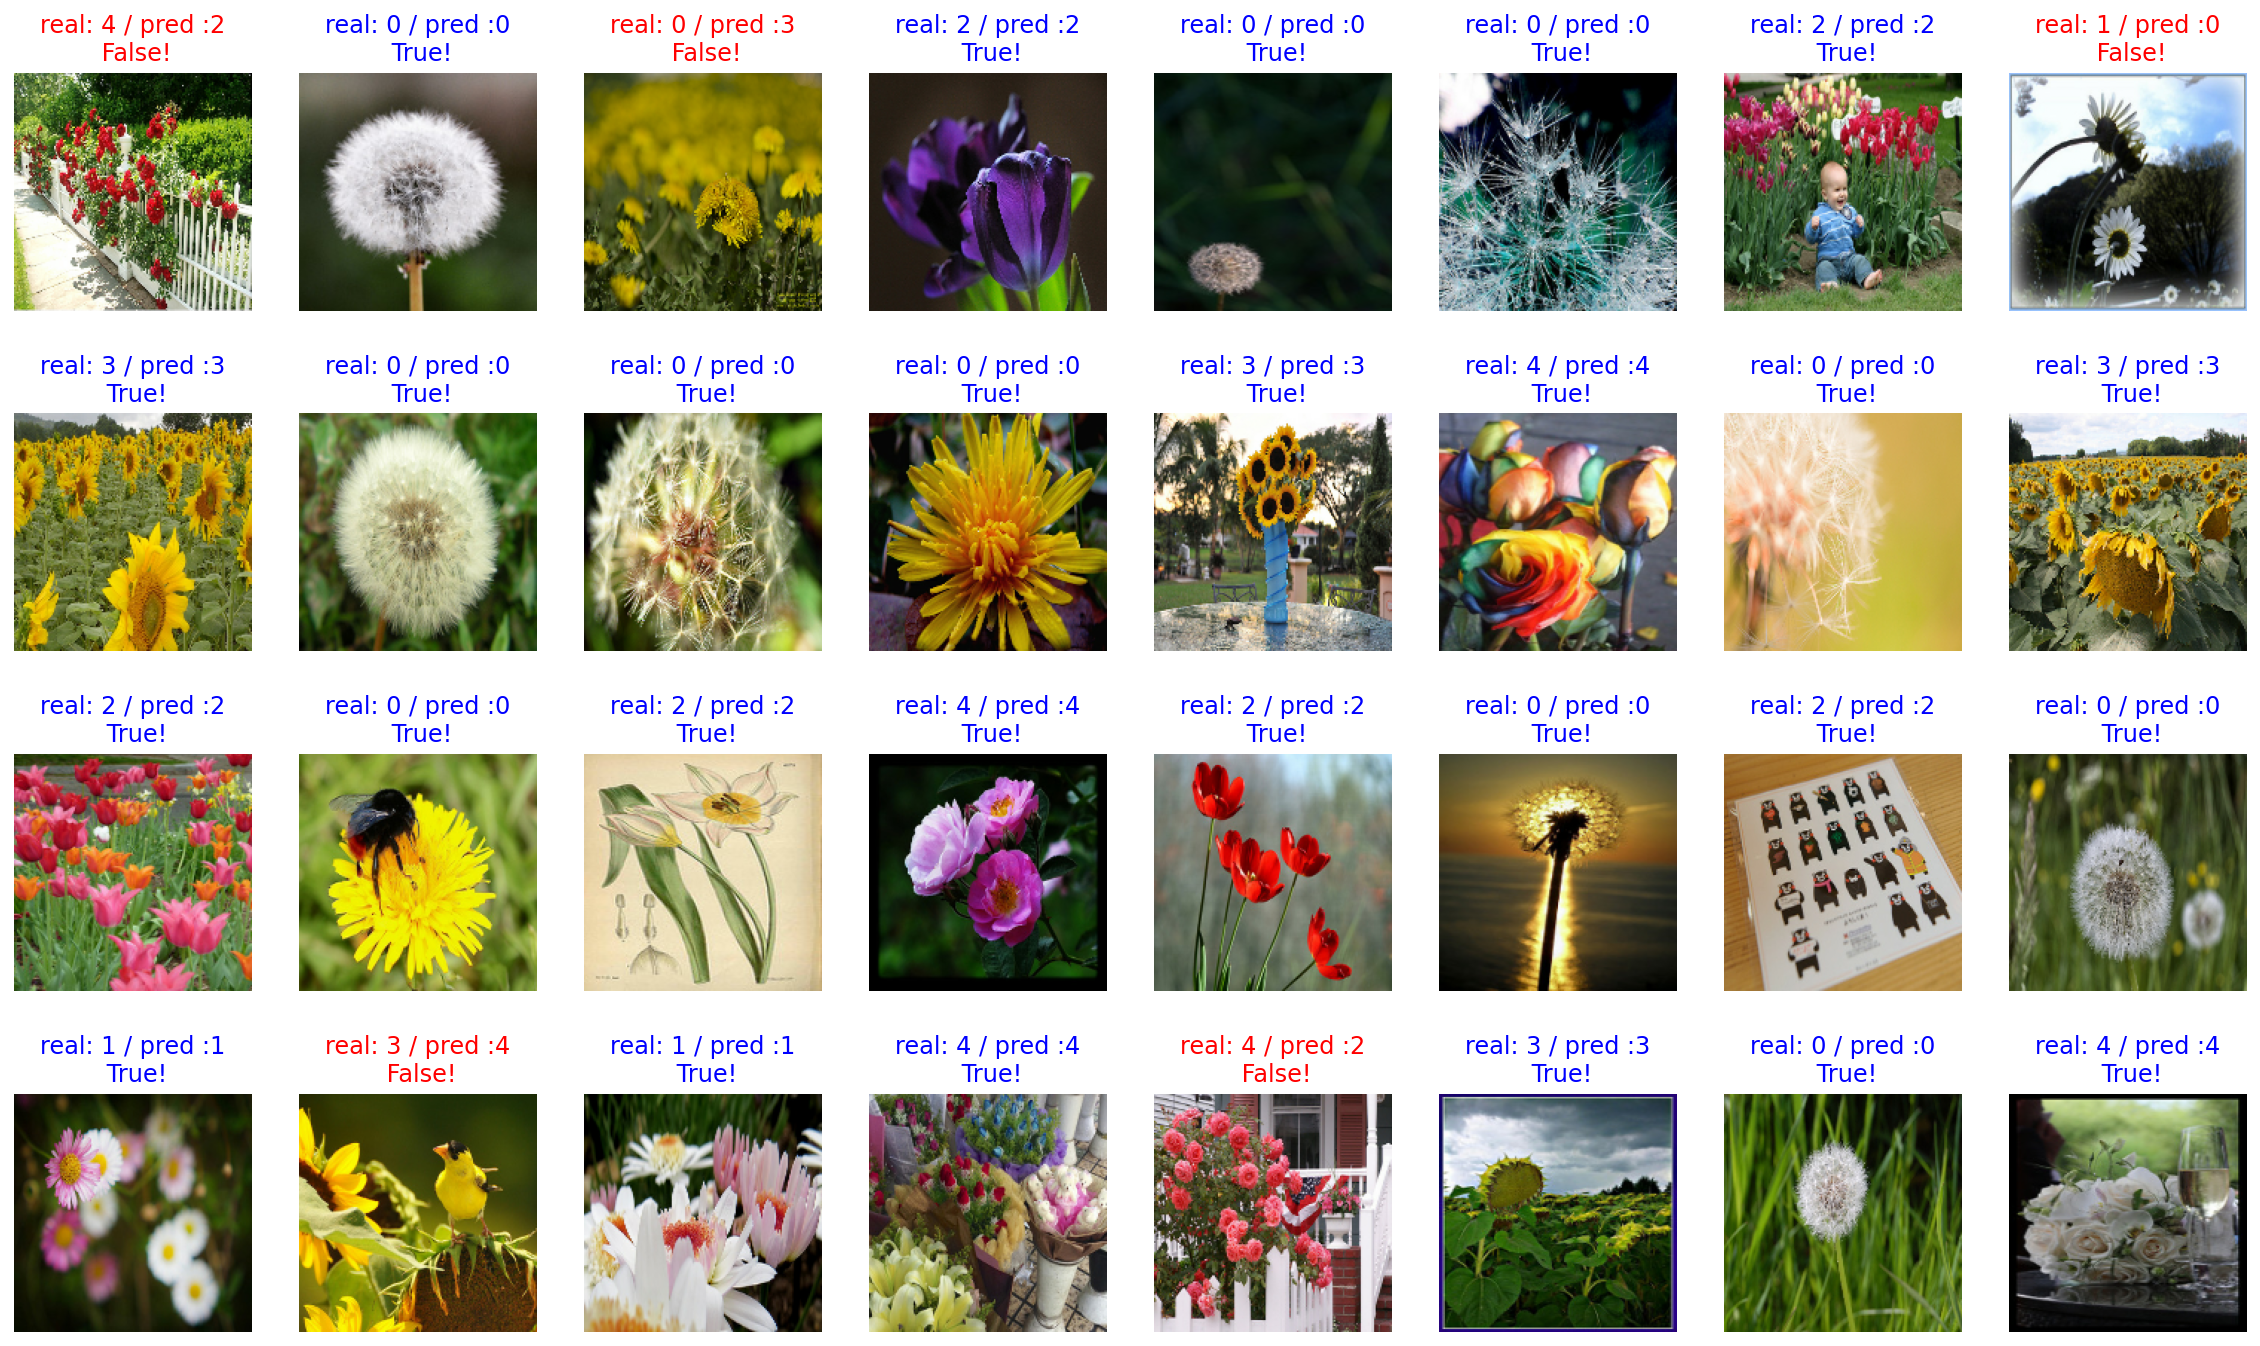

In [21]:
# 실제 test set 분류 결과 확인

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [22]:
# 정확도 확인

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 84% 내외

84.375


Step 6. 모델 활용하기

 - 원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해보기

In [23]:
# 경로 설정을 위한 라이브러리 호출
import os

# 분류할 이미지의 경로를 변수에 저장
img_dir_path = os.getenv("HOME") + "/aiffel/flower_classifier/images"
os.path.exists(img_dir_path)

True

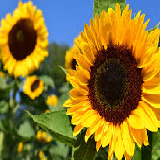

In [24]:
# 분류할 이미지를 모델 입력 사이즈에 맞게 전처리

# 이미지 전처리 라이브러리 호출
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 전처리 이미지 경로 설정
test_sun_image_path = os.path.join(img_dir_path, 'test_sun.jpeg')

# 이미지의 사이즈를 변환하여 변수에 저장
IMG_SIZE = 160
test_sun_image = load_img(test_sun_image_path, target_size=(IMG_SIZE, IMG_SIZE))
test_sun_image

In [25]:
# 이미지 데이터의 행렬 사이즈를 모델 함수에 입력 할 수 있도록 변환
test_sun_image = img_to_array(test_sun_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
test_sun_image.shape

(1, 160, 160, 3)

In [26]:
# 모델을 이용하여 이미지 예측 분류

predictions = model.predict(test_sun_image)

predictions = np.around(predictions)

predictions


array([[0., 0., 0., 1., 0.]], dtype=float32)

In [27]:
# 예측 값을 받아 결과를 출력하는 함수 정의 및 실행

def show_and_predict_image(prediction):
    

    for i in range(5):
        if predictions[0][i] == 1:
            if i == 0:
                print("This is dandelion")
            elif i == 1:
                print("This is daisy")
            elif i == 2:
                print("This is tulips")
            elif i == 3:
                print("This is sunflowers")
            elif i == 4:
                print("This is roses")



show_and_predict_image(prediction)

This is sunflowers


# 결과

 - 마지막 입력한 이미지인 해바라기에 대해 잘 분류하였고, test_batches에 대해서도 어느 정도 분류 성과를 보인 것을 확인할 수 있었습니다.
 - validation Data 기준으로는 88% 정도의 정확도를 보였으나, 실제로 분류한 이미지에서는 84%정도의 정확도를 보인 것으로 보아 실제로 사용하기 위해서는 정확도를 더 높이는 것이 중요하다고 생각합니다.
 - 아직 딥러닝에 대한 이론 학습을 하기전에 미리 실습을 해본 것 이므로, 추후 CS231n과 LMS Fundamental 수업의 딥러닝 파트를 수강 후, 각 레이어의 특성과 파라미터의 의미를 이해 한 후, 값을 변경해가며 모델을 최적화 시킨다면, 분류기의 정확도가 향상 될 것으로 생각 됩니다. 
 - 마지막 결과 도출 함수에 대해서는 이미지를 불러와 전처리하고 예측하는 과정이 중복되어 있어서 제거하고 간단하게 출력하도록 변경 하였습니다.